In [1]:
%pylab inline
import numpy as np
from math import pi, log
from matplotlib import pyplot as plt
from scipy import signal

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import fft, ifft
from scipy.optimize import curve_fit
 
def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise (ValueError, 
                'Input vectors y_axis and x_axis must have same length')
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis
    
def _peakdetect_parabole_fitter(raw_peaks, x_axis, y_axis, points):
    """
    Performs the actual parabole fitting for the peakdetect_parabole function.
    
    keyword arguments:
    raw_peaks -- A list of either the maximium or the minimum peaks, as given
        by the peakdetect_zero_crossing function, with index used as x-axis
    x_axis -- A numpy list of all the x values
    y_axis -- A numpy list of all the y values
    points -- How many points around the peak should be used during curve
        fitting, must be odd.
    
    return -- A list giving all the peaks and the fitted waveform, format:
        [[x, y, [fitted_x, fitted_y]]]
        
    """
    func = lambda x, k, tau, m: k * ((x - tau) ** 2) + m
    fitted_peaks = []
    for peak in raw_peaks:
        index = peak[0]
        x_data = x_axis[index - points // 2: index + points // 2 + 1]
        y_data = y_axis[index - points // 2: index + points // 2 + 1]
        # get a first approximation of tau (peak position in time)
        tau = x_axis[index]
        # get a first approximation of peak amplitude
        m = peak[1]
        
        # build list of approximations
        # k = -m as first approximation?
        p0 = (-m, tau, m)
        popt, pcov = curve_fit(func, x_data, y_data, p0)
        # retrieve tau and m i.e x and y value of peak
        x, y = popt[1:3]
        
        # create a high resolution data set for the fitted waveform
        x2 = np.linspace(x_data[0], x_data[-1], points * 10)
        y2 = func(x2, *popt)
        
        fitted_peaks.append([x, y, [x2, y2]])
        
    return fitted_peaks
    
    
def peakdetect(y_axis, x_axis = None, lookahead = 300, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    
    function for detecting local maximas and minmias in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maximas and minimas respectively
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- (optional) A x-axis whose values correspond to the y_axis list
        and is used in the return to specify the postion of the peaks. If
        omitted an index of the y_axis is used. (default: None)
    lookahead -- (optional) distance to look ahead from a peak candidate to
        determine if it is the actual peak (default: 200) 
        '(sample / period) / f' where '4 >= f >= 1.25' might be a good value
    delta -- (optional) this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            delta function causes a 20% decrease in speed, when omitted
            Correctly used it can double the speed of the function
    
    return -- two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tupple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*tab)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError, "Lookahead must be '1' or above in value"
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError, "delta must be a positive number"
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        #no peaks were found, should the function return empty lists?
        pass
        
    return [max_peaks, min_peaks]
    
    
def peakdetect_fft(y_axis, x_axis, pad_len = 5):
    """
    Performs a FFT calculation on the data and zero-pads the results to
    increase the time domain resolution after performing the inverse fft and
    send the data to the 'peakdetect' function for peak 
    detection.
    
    Omitting the x_axis is forbidden as it would make the resulting x_axis
    value silly if it was returned as the index 50.234 or similar.
    
    Will find at least 1 less peak then the 'peakdetect_zero_crossing'
    function, but should result in a more precise value of the peak as
    resolution has been increased. Some peaks are lost in an attempt to
    minimize spectral leakage by calculating the fft between two zero
    crossings for n amount of signal periods.
    
    The biggest time eater in this function is the ifft and thereafter it's
    the 'peakdetect' function which takes only half the time of the ifft.
    Speed improvementd could include to check if 2**n points could be used for
    fft and ifft or change the 'peakdetect' to the 'peakdetect_zero_crossing',
    which is maybe 10 times faster than 'peakdetct'. The pro of 'peakdetect'
    is that it resutls in one less lost peak. It should also be noted that the
    time used by the ifft function can change greatly depending on the input.
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the postion of the peaks.
    pad_len -- (optional) By how many times the time resolution should be
        increased by, e.g. 1 doubles the resolution. The amount is rounded up
        to the nearest 2 ** n amount (default: 5)
    
    return -- two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tupple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*tab)
    """
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    zero_indices = zero_crossings(y_axis, window = 11)
    #select a n amount of periods
    last_indice = - 1 - (1 - len(zero_indices) & 1)
    # Calculate the fft between the first and last zero crossing
    # this method could be ignored if the begining and the end of the signal
    # are discardable as any errors induced from not using whole periods
    # should mainly manifest in the beginning and the end of the signal, but
    # not in the rest of the signal
    fft_data = fft(y_axis[zero_indices[0]:zero_indices[last_indice]])
    padd = lambda x, c: x[:len(x) // 2] + [0] * c + x[len(x) // 2:]
    n = lambda x: int(log(x)/log(2)) + 1
    # padds to 2**n amount of samples
    fft_padded = padd(list(fft_data), 2 ** 
                n(len(fft_data) * pad_len) - len(fft_data))
    
    # There is amplitude decrease directly proportional to the sample increase
    sf = len(fft_padded) / float(len(fft_data))
    # There might be a leakage giving the result an imaginary component
    # Return only the real component
    y_axis_ifft = ifft(fft_padded).real * sf #(pad_len + 1)
    x_axis_ifft = np.linspace(
                x_axis[zero_indices[0]], x_axis[zero_indices[last_indice]],
                len(y_axis_ifft))
    # get the peaks to the interpolated waveform
    max_peaks, min_peaks = peakdetect(y_axis_ifft, x_axis_ifft, 500,
                                    delta = abs(np.diff(y_axis).max() * 2))
    #max_peaks, min_peaks = peakdetect_zero_crossing(y_axis_ifft, x_axis_ifft)
    
    # store one 20th of a period as waveform data
    data_len = int(np.diff(zero_indices).mean()) / 10
    data_len += 1 - data_len & 1
    
    
    fitted_wave = []
    for peaks in [max_peaks, min_peaks]:
        peak_fit_tmp = []
        index = 0
        for peak in peaks:
            index = np.where(x_axis_ifft[index:]==peak[0])[0][0] + index
            x_fit_lim = x_axis_ifft[index - data_len // 2:
                                    index + data_len // 2 + 1]
            y_fit_lim = y_axis_ifft[index - data_len // 2:
                                    index + data_len // 2 + 1]
            
            peak_fit_tmp.append([x_fit_lim, y_fit_lim])
        fitted_wave.append(peak_fit_tmp)
    
    #pylab.plot(range(len(fft_data)), fft_data)
    #pylab.show()
    
    pylab.plot(x_axis, y_axis)
    pylab.hold(True)
    pylab.plot(x_axis_ifft, y_axis_ifft)
    #for max_p in max_peaks:
    #    pylab.plot(max_p[0], max_p[1], 'xr')
    pylab.show()
    return [max_peaks, min_peaks]
    
    
def peakdetect_parabole(y_axis, x_axis, points = 9):
    """
    Function for detecting local maximas and minmias in a signal.
    Discovers peaks by fitting the model function: y = k (x - tau) ** 2 + m
    to the peaks. The amount of points used in the fitting is set by the
    points argument.
    
    Omitting the x_axis is forbidden as it would make the resulting x_axis
    value silly if it was returned as index 50.234 or similar.
    
    will find the same amount of peaks as the 'peakdetect_zero_crossing'
    function, but might result in a more precise value of the peak.
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the postion of the peaks.
    points -- (optional) How many points around the peak should be used during
        curve fitting, must be odd (default: 9)
    
    return -- two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a list
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # make the points argument odd
    points += 1 - points % 2
    #points += 1 - int(points) & 1 slower when int conversion needed
    
    # get raw peaks
    max_raw, min_raw = peakdetect_zero_crossing(y_axis)
    
    # define output variable
    max_peaks = []
    min_peaks = []
    
    max_ = _peakdetect_parabole_fitter(max_raw, x_axis, y_axis, points)
    min_ = _peakdetect_parabole_fitter(min_raw, x_axis, y_axis, points)
    
    max_peaks = map(lambda x: [x[0], x[1]], max_)
    max_fitted = map(lambda x: x[-1], max_)
    min_peaks = map(lambda x: [x[0], x[1]], min_)
    min_fitted = map(lambda x: x[-1], min_)
    
    
    #pylab.plot(x_axis, y_axis)
    #pylab.hold(True)
    #for max_p, max_f in zip(max_peaks, max_fitted):
    #    pylab.plot(max_p[0], max_p[1], 'x')
    #    pylab.plot(max_f[0], max_f[1], 'o', markersize = 2)
    #for min_p, min_f in zip(min_peaks, min_fitted):
    #    pylab.plot(min_p[0], min_p[1], 'x')
    #    pylab.plot(min_f[0], min_f[1], 'o', markersize = 2)
    #pylab.show()
    
    return [max_peaks, min_peaks]
    
 
def peakdetect_sine(y_axis, x_axis, points = 9, lock_frequency = False):
    """
    Function for detecting local maximas and minmias in a signal.
    Discovers peaks by fitting the model function:
    y = A * sin(2 * pi * f * x - tau) to the peaks. The amount of points used
    in the fitting is set by the points argument.
    
    Omitting the x_axis is forbidden as it would make the resulting x_axis
    value silly if it was returned as index 50.234 or similar.
    
    will find the same amount of peaks as the 'peakdetect_zero_crossing'
    function, but might result in a more precise value of the peak.
    
    The function might have some problems if the sine wave has a
    non-negligible total angle i.e. a k*x component, as this messes with the
    internal offset calculation of the peaks, might be fixed by fitting a 
    k * x + m function to the peaks for offset calculation.
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the postion of the peaks.
    points -- (optional) How many points around the peak should be used during
        curve fitting, must be odd (default: 9)
    lock_frequency -- (optional) Specifies if the frequency argument of the
        model function should be locked to the value calculated from the raw
        peaks or if optimization process may tinker with it. (default: False)
    
    return -- two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tupple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*tab)
    """
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # make the points argument odd
    points += 1 - points % 2
    #points += 1 - int(points) & 1 slower when int conversion needed
    
    # get raw peaks
    max_raw, min_raw = peakdetect_zero_crossing(y_axis)
    
    # define output variable
    max_peaks = []
    min_peaks = []
    
    # get global offset
    offset = np.mean([np.mean(max_raw, 0)[1], np.mean(min_raw, 0)[1]])
    # fitting a k * x + m function to the peaks might be better
    #offset_func = lambda x, k, m: k * x + m
    
    # calculate an approximate frequenzy of the signal
    Hz = []
    for raw in [max_raw, min_raw]:
        if len(raw) > 1:
            peak_pos = [x_axis[index] for index in zip(*raw)[0]]
            Hz.append(np.mean(np.diff(peak_pos)))
    Hz = 1 / np.mean(Hz)
    
    # model function
    # if cosine is used then tau could equal the x position of the peak
    # if sine were to be used then tau would be the first zero crossing
    if lock_frequency:
        func = lambda x, A, tau: A * np.sin(2 * pi * Hz * (x - tau) + pi / 2)
    else:
        func = lambda x, A, Hz, tau: A * np.sin(2 * pi * Hz * (x - tau) + 
                                                pi / 2)
    #func = lambda x, A, Hz, tau: A * np.cos(2 * pi * Hz * (x - tau))
    
    
    #get peaks
    fitted_peaks = []
    for raw_peaks in [max_raw, min_raw]:
        peak_data = []
        for peak in raw_peaks:
            index = peak[0]
            x_data = x_axis[index - points // 2: index + points // 2 + 1]
            y_data = y_axis[index - points // 2: index + points // 2 + 1]
            # get a first approximation of tau (peak position in time)
            tau = x_axis[index]
            # get a first approximation of peak amplitude
            A = peak[1]
            
            # build list of approximations
            if lock_frequency:
                p0 = (A, tau)
            else:
                p0 = (A, Hz, tau)
            
            # subtract offset from waveshape
            y_data -= offset
            popt, pcov = curve_fit(func, x_data, y_data, p0)
            # retrieve tau and A i.e x and y value of peak
            x = popt[-1]
            y = popt[0]
            
            # create a high resolution data set for the fitted waveform
            x2 = np.linspace(x_data[0], x_data[-1], points * 10)
            y2 = func(x2, *popt)
            
            # add the offset to the results
            y += offset
            y2 += offset
            y_data += offset
            
            peak_data.append([x, y, [x2, y2]])
       
        fitted_peaks.append(peak_data)
    
    # structure date for output
    max_peaks = map(lambda x: [x[0], x[1]], fitted_peaks[0])
    max_fitted = map(lambda x: x[-1], fitted_peaks[0])
    min_peaks = map(lambda x: [x[0], x[1]], fitted_peaks[1])
    min_fitted = map(lambda x: x[-1], fitted_peaks[1])
    
    
    #pylab.plot(x_axis, y_axis)
    #pylab.hold(True)
    #for max_p, max_f in zip(max_peaks, max_fitted):
    #    pylab.plot(max_p[0], max_p[1], 'x')
    #    pylab.plot(max_f[0], max_f[1], 'o', markersize = 2)
    #for min_p, min_f in zip(min_peaks, min_fitted):
    #    pylab.plot(min_p[0], min_p[1], 'x')
    #    pylab.plot(min_f[0], min_f[1], 'o', markersize = 2)
    #pylab.show()
    
    return [max_peaks, min_peaks]
 
    
def peakdetect_sine_locked(y_axis, x_axis, points = 9):
    """
    Convinience function for calling the 'peakdetect_sine' function with
    the lock_frequency argument as True.
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the postion of the peaks.
    points -- (optional) How many points around the peak should be used during
        curve fitting, must be odd (default: 9)
        
    return -- see 'peakdetect_sine'
    """
    return peakdetect_sine(y_axis, x_axis, points, True)
    
    
def peakdetect_zero_crossing(y_axis, x_axis = None, window = 11):
    """
    Function for detecting local maximas and minmias in a signal.
    Discovers peaks by dividing the signal into bins and retrieving the
    maximum and minimum value of each the even and odd bins respectively.
    Division into bins is performed by smoothing the curve and finding the
    zero crossings.
    
    Suitable for repeatable signals, where some noise is tolerated. Excecutes
    faster than 'peakdetect', although this function will break if the offset
    of the signal is too large. It should also be noted that the first and
    last peak will probably not be found, as this function only can find peaks
    between the first and last zero crossing.
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- (optional) A x-axis whose values correspond to the y_axis list
        and is used in the return to specify the postion of the peaks. If
        omitted an index of the y_axis is used. (default: None)
    window -- the dimension of the smoothing window; should be an odd integer
        (default: 11)
    
    return -- two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tupple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*tab)
    """
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    
    zero_indices = zero_crossings(y_axis, window = window)
    period_lengths = np.diff(zero_indices)
            
    bins_y = [y_axis[index:index + diff] for index, diff in 
        zip(zero_indices, period_lengths)]
    bins_x = [x_axis[index:index + diff] for index, diff in 
        zip(zero_indices, period_lengths)]
        
    even_bins_y = bins_y[::2]
    odd_bins_y = bins_y[1::2]
    even_bins_x = bins_x[::2]
    odd_bins_x = bins_x[1::2]
    hi_peaks_x = []
    lo_peaks_x = []
    
    #check if even bin contains maxima
    if abs(even_bins_y[0].max()) > abs(even_bins_y[0].min()):
        hi_peaks = [bin.max() for bin in even_bins_y]
        lo_peaks = [bin.min() for bin in odd_bins_y]
        # get x values for peak
        for bin_x, bin_y, peak in zip(even_bins_x, even_bins_y, hi_peaks):
            hi_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
        for bin_x, bin_y, peak in zip(odd_bins_x, odd_bins_y, lo_peaks):
            lo_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
    else:
        hi_peaks = [bin.max() for bin in odd_bins_y]
        lo_peaks = [bin.min() for bin in even_bins_y]
        # get x values for peak
        for bin_x, bin_y, peak in zip(odd_bins_x, odd_bins_y, hi_peaks):
            hi_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
        for bin_x, bin_y, peak in zip(even_bins_x, even_bins_y, lo_peaks):
            lo_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
    
    max_peaks = [[x, y] for x,y in zip(hi_peaks_x, hi_peaks)]
    min_peaks = [[x, y] for x,y in zip(lo_peaks_x, lo_peaks)]
    
    return [max_peaks, min_peaks]
        
    
def _smooth(x, window_len=11, window='hanning'):
    """
    smooth the data using a window of the requested size.
    
    This method is based on the convolution of a scaled window on the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd 
            integer
        window: the type of window from 'flat', 'hanning', 'hamming', 
            'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
 
    output:
        the smoothed signal
        
    example:
 
    t = linspace(-2,2,0.1)
    x = sin(t)+randn(len(t))*0.1
    y = _smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, 
    numpy.convolve, scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if a list instead of
    a string   
    """
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."
 
    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
    
    if window_len<3:
        return x
    
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError,
            "Window is not one of '{0}', '{1}', '{2}', '{3}', '{4}'".format(
            *('flat', 'hanning', 'hamming', 'bartlett', 'blackman')))
    
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.' + window + '(window_len)')
 
    y = np.convolve(w / w.sum(), s, mode = 'valid')
    return y
    
    
def zero_crossings(y_axis, window = 11):
    """
    Algorithm to find zero crossings. Smoothens the curve and finds the
    zero-crossings by looking for a sign change.
    
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find zero-crossings
    window -- the dimension of the smoothing window; should be an odd integer
        (default: 11)
    
    return -- the index for each zero-crossing
    """
    # smooth the curve
    length = len(y_axis)
    x_axis = np.asarray(range(length), int)
    
    # discard tail of smoothed signal
    y_axis = _smooth(y_axis, window)[:length]
    zero_crossings = np.where(np.diff(np.sign(y_axis)))[0]
    indices = [x_axis[index] for index in zero_crossings]
    
    # check if zero-crossings are valid
    diff = np.diff(indices)
    if diff.std() / diff.mean() > 0.2:
        print diff.std() / diff.mean()
        print np.diff(indices)
        raise(ValueError, 
            "False zero-crossings found, indicates problem {0} or {1}".format(
            "with smoothing window", "problem with offset"))
    # check if any zero crossings were found
    if len(zero_crossings) < 1:
        raise(ValueError, "No zero crossings found")
    
    return indices 
    # used this to test the fft function's sensitivity to spectral leakage
    #return indices + np.asarray(30 * np.random.randn(len(indices)), int)
    
############################Frequency calculation#############################
#    diff = np.diff(indices)
#    time_p_period = diff.mean()
#    
#    if diff.std() / time_p_period > 0.1:
#        raise ValueError, 
#            "smoothing window too small, false zero-crossing found"
#    
#    #return frequency
#    return 1.0 / time_p_period
##############################################################################
 
 

[315.0, 369.5, 378.5, 444.0, 459.0, 477.0, 485.5, 490.5]
[ 295.   315.5  327.5  368.5  379.5  409.   428.   444.   458.   477.   486.
  494.5]


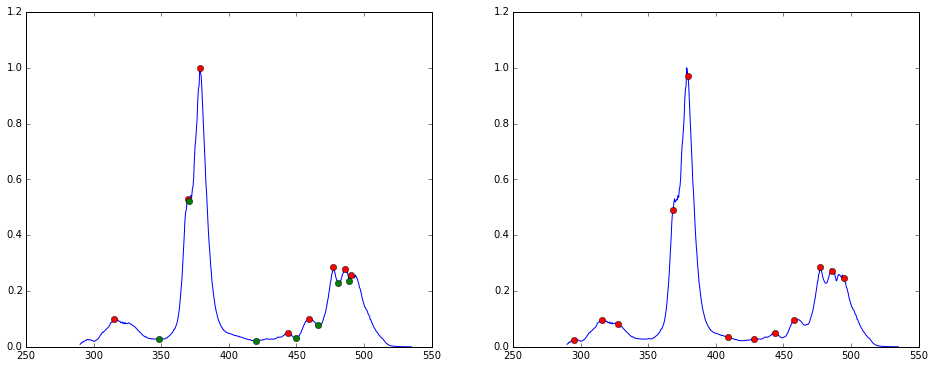

In [3]:
path="/Users/stanpol/Python/"
fig = plt.figure(figsize=[16,6])
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

with open(path+"sample4nf.dat") as f:
	data = np.loadtxt(f, unpack=True, skiprows=2)
data[-1] = data[-1]/data[-1].max()
a1, = ax.plot(data[0], data[-1], 'b')
a2, = ax2.plot(data[0], data[-1], 'b')
ax.set_ylim([0,1.2])
ax2.set_ylim([0,1.2])

_max, _min = peakdetect(data[-1], data[0], 1, 0.01)
xm = [p[0] for p in _max]
ym = [p[1] for p in _max]
xn = [p[0] for p in _min]
yn = [p[1] for p in _min]
print xm
ax.plot(xm, ym, 'ro')
ax.plot(xn, yn, 'go')

peakind = signal.find_peaks_cwt(data[-1], np.arange(1,25)) 
ax2.plot(data[0][peakind], data[-1][peakind], 'ro')
print data[0][peakind]
plt.show()